# Introduction to scvi-tools

In this introductory tutorial, we go through the different steps of an scvi-tools workflow.

While we focus on scVI in this tutorial, the API is consistent across all models.

In [1]:
import scanpy as sc
import pandas as pd
import scvi
import os
import anndata
sc.set_figure_params(figsize=(4, 4))

name = '10X_P7_4'
Data_path = '../filtered_dataset/tabulamuris/data_'+name+'/'
save_path = '../results/scvi/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0


## Loading and preparing data

Let us first load a subsampled version of the heart cell atlas dataset described in Litviňuková et al. (2020). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. Please see our tutorial on data loading for more examples.

- Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

<div class="alert alert-info">
Important

All scvi-tools models require AnnData objects as input.

</div>

In [2]:
adata = sc.read_10x_mtx(Data_path)
adata

AnnData object with n_obs × n_vars = 370 × 13656
    var: 'gene_ids'

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

In [3]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata)
adata.raw = adata  # freeze the state in `.raw`
adata

AnnData object with n_obs × n_vars = 370 × 13656
    var: 'gene_ids'
    layers: 'counts'

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

In [4]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [5]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
)

<div class="alert alert-warning">

Warning

If the adata is modified after running `setup_anndata`, please run `setup_anndata` again, before creating an instance of a model.

</div>

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [6]:
if os.path.exists(name+'model/'):
    model = scvi.model.SCVI.load(name+'model/', adata=adata, use_gpu=True)
else:
    model = scvi.model.SCVI(adata)
    model.train(use_gpu=False)
    model.save(name+'model/')
    
    
model

INFO     File 10X_P7_4model/model.pt already downloaded                                                            


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

We can see an overview of the model by printing it.

## Obtaining model outputs

In [7]:
latent = model.get_latent_representation()

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [8]:
adata.obsm["X_scVI"] = latent
adata_subset = adata

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

In [9]:
latent_subset = model.get_latent_representation(adata_subset)

In [10]:
denoised = model.get_normalized_expression(adata_subset)
denoised.iloc[:5, :5]

,Sox17,Sntg1,Sulf1,Msc,Pi15
AAACCTGCACGACGAA,0.002731,0.000022,0.000147,0.000083,0.000078
AAACCTGGTTCCACGG,0.000017,0.000113,0.000809,0.000677,0.001324
AAACCTGTCTCGATGA,0.000292,0.000023,0.000017,0.000027,0.000147
AAACGGGAGCGCTCCA,0.000043,0.000008,0.000003,0.000004,0.000011
AAAGCAAAGTGAATTG,0.000017,0.000011,0.000210,0.000033,0.000093


Let's store the normalized values back in the anndata.

In [11]:
adata.layers["scvi_normalized"] = model.get_normalized_expression()

## Interoperability with Scanpy

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

### Visualization without batch correction

<div class="alert alert-warning">

Warning

We use UMAP to *qualitatively* assess our low-dimension embeddings of cells. We do not advise using UMAP or any similar approach quantitatively. We do recommend using the embeddings produced by scVI as a plug-in replacement of what you would get from PCA, as we show below.

</div>

First, we demonstrate the presence of nuisance variation with respect to nuclei/whole cell, age group, and donor by plotting the UMAP results of the top 30 PCA components for the raw count data.

In [12]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.05)
adata

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-pac

AnnData object with n_obs × n_vars = 370 × 1200
    obs: '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

We see that while the cell types are generally well separated, nuisance variation plays a large part in the variation of the data.

### Visualization with batch correction (scVI)

Now, let us try using the scVI latent space to generate the same UMAP plots to see if scVI successfully accounts for batch effects in the data.

In [13]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

We can see that scVI was able to correct for nuisance variation due to nuclei/whole cell, age group, and donor, while maintaining separation of cell types.

### Clustering on the scVI latent space

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI (e.g., for differential expression).

In [14]:
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.06)

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


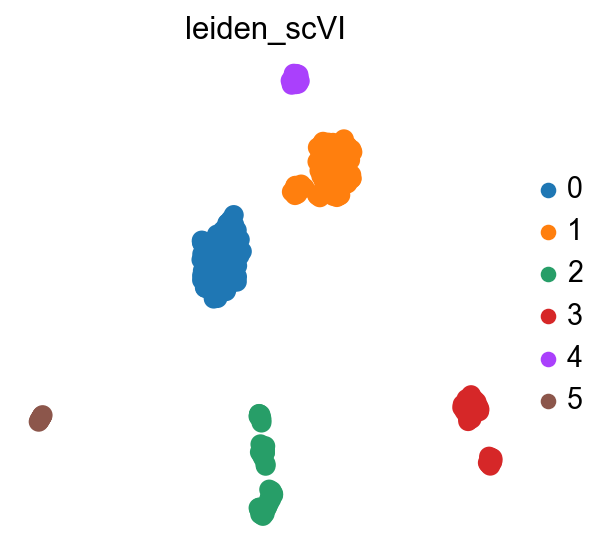

AnnData object with n_obs × n_vars = 370 × 1200
    obs: '_scvi_batch', '_scvi_labels', 'leiden_scVI'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_scVI_colors'
    obsm: 'X_scVI', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [15]:
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False,
)
adata

In [16]:
# silouhette score
matrix = adata.X

from sklearn.metrics import silhouette_score
score = silhouette_score(matrix, adata.obs.leiden_scVI, metric='euclidean')

# dataset with silouette score

df = pd.DataFrame([score], columns=['silhouette'])
df.to_csv(save_path+'clustering_scores_10X_P7_4.csv', index=False)

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


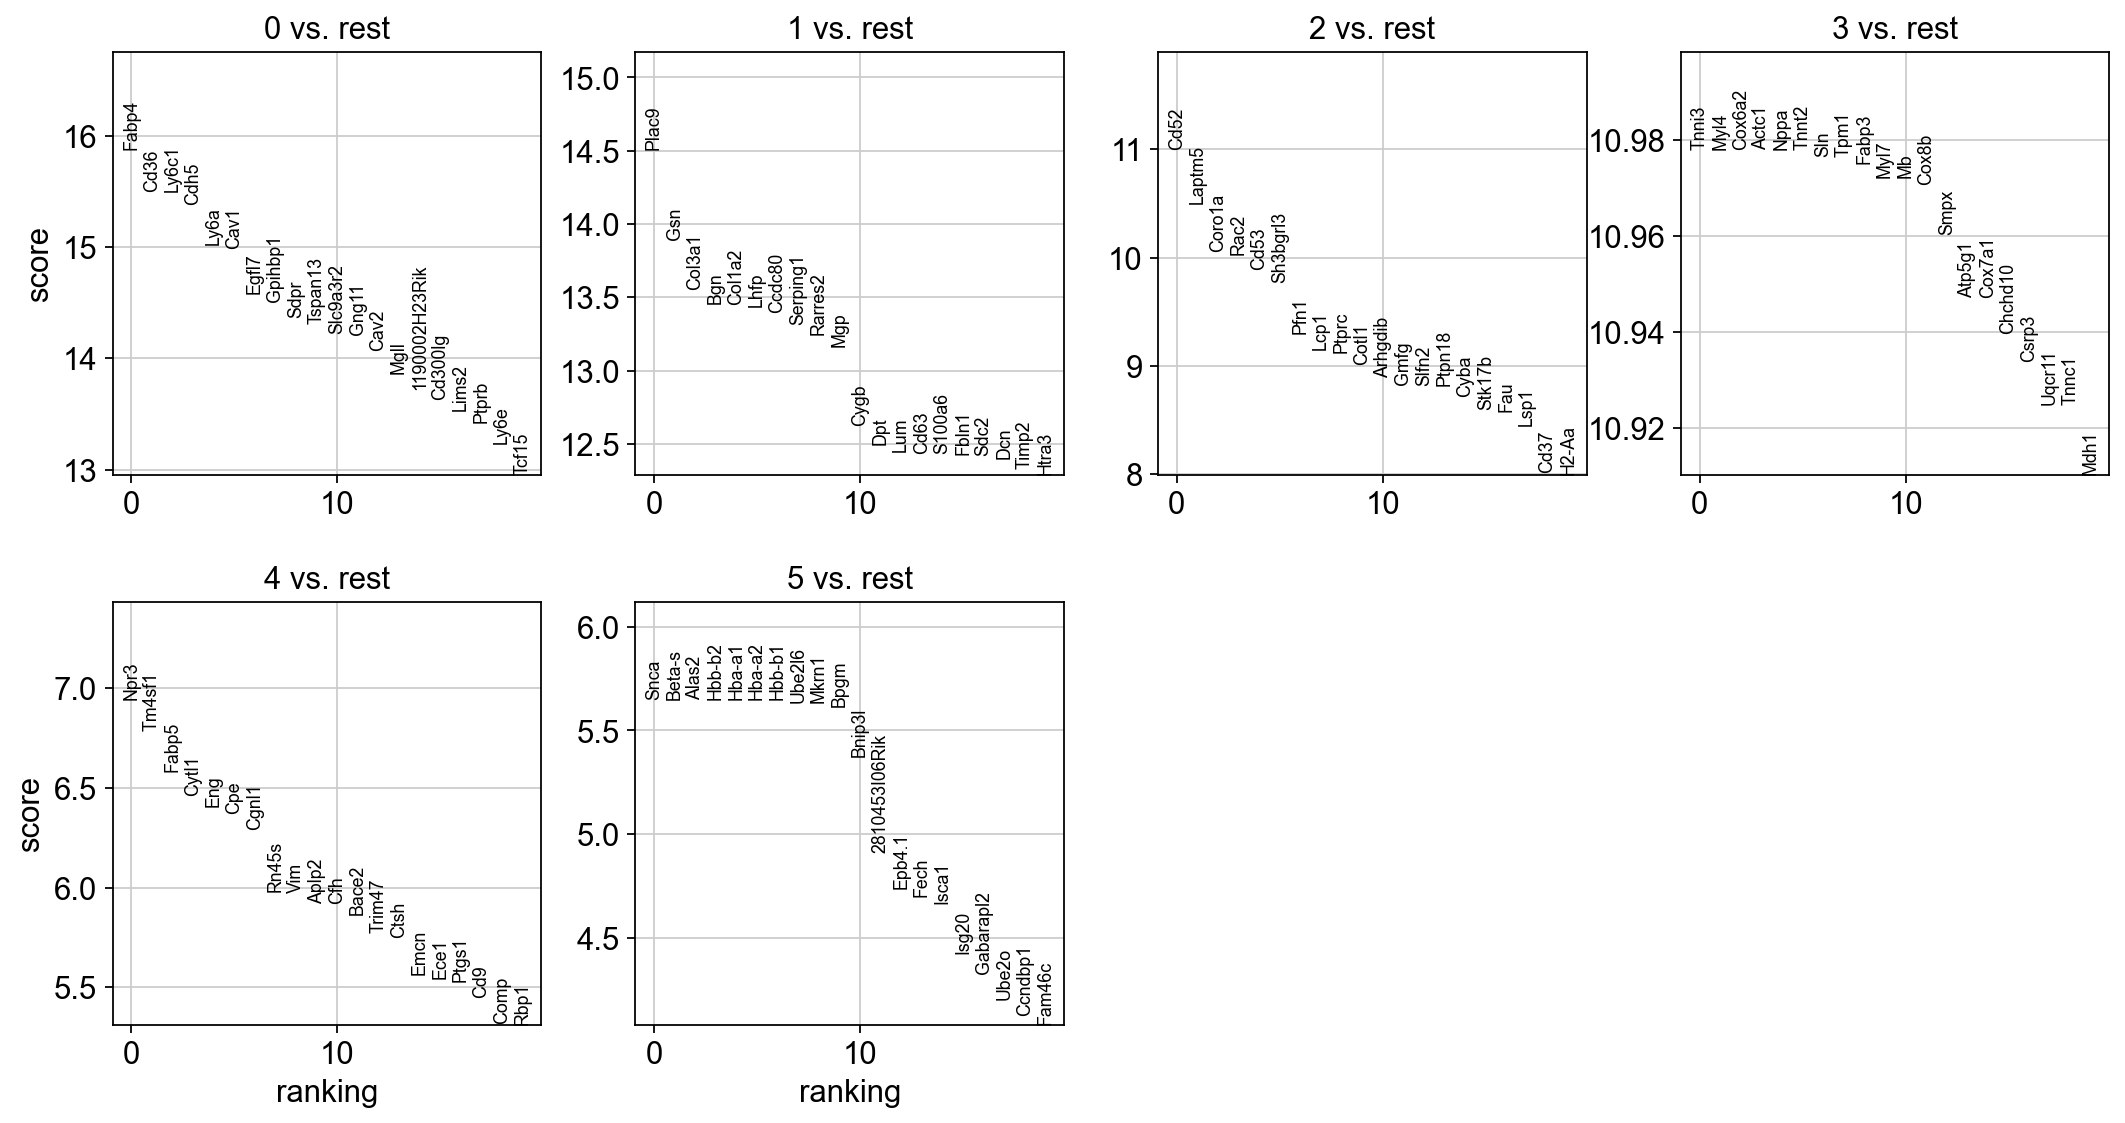

In [17]:
sc.tl.rank_genes_groups(adata, 'leiden_scVI', method='wilcoxon') # method='wilcoxon' method='logreg'
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [18]:
number_of_clusters = 6
number_of_genes = 20

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(number_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] += 1
df['rank'] += 1

df.to_csv(save_path+'markers_10X_P7_4.csv', index=False)

In [19]:

df = pd.DataFrame(adata.obs['leiden_scVI'])

labels = df.rename(columns={'leiden_scVI': 'cluster'})
# rename index as cell
labels.index.names = ['cell']

labels['cluster'] = labels['cluster'].astype(int) + 1


labels.to_csv(save_path+'clustering_labels_10X_P7_4.csv')

## Differential expression
We can also use many scvi-tools models for differential expression. For further details on the methods underlying these functions as well as additional options, please see the [API docs](https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.differential_expression.html#scvi.model.SCVI.differential_expression).

In [20]:
adata.obs.leiden_scVI.head()

AAACCTGCACGACGAA    0
AAACCTGGTTCCACGG    1
AAACCTGTCTCGATGA    0
AAACGGGAGCGCTCCA    2
AAAGCAAAGTGAATTG    1
Name: leiden_scVI, dtype: category
Categories (6, object): ['0', '1', '2', '3', '4', '5']

For example, a 1-vs-1 DE test is as simple as:

In [21]:
de_df = model.differential_expression(
    groupby="leiden_scVI")
de_df.head()

DE...: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
C1qtnf9,0.9998,0.0002,8.516943,0.005873,0.000036,0.0,0.25,8.767330,8.814924,2.425634,...,2.492423,0.063025,0.818182,0.037815,60.751797,0.335000,True,0 vs Rest,0,Rest
Mgll,0.9998,0.0002,8.516943,0.011836,0.000165,0.0,0.25,6.876250,7.007739,1.786474,...,4.863637,0.142857,0.886364,0.117647,117.763741,1.410579,True,0 vs Rest,0,Rest
Ly6c1,0.9998,0.0002,8.516943,0.039202,0.000524,0.0,0.25,7.085183,7.114923,1.692010,...,16.356068,0.319328,0.977273,0.163866,407.358429,2.279522,True,0 vs Rest,0,Rest
Fabp4,0.9994,0.0006,7.417964,0.114014,0.001619,0.0,0.25,7.160820,7.433257,1.767387,...,80.772705,1.890757,1.000000,0.495798,1929.045410,13.605830,True,0 vs Rest,0,Rest
Ptprb,0.9994,0.0006,7.417964,0.007329,0.000177,0.0,0.25,6.204839,6.243855,1.698398,...,2.803028,0.126050,0.863636,0.079832,69.513977,1.063649,True,0 vs Rest,0,Rest


We can also do a 1-vs-all DE test, which compares each cell type with the rest of the dataset:

In [22]:
de_df = model.differential_expression(
    groupby="leiden_scVI",
)
de_df.head()

DE...: 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Ly6c1,0.9998,0.0002,8.516943,0.038951,0.000533,0.0,0.25,7.078909,7.152165,1.697779,...,16.356068,0.319328,0.977273,0.163866,407.358429,2.279522,True,0 vs Rest,0,Rest
Fabp4,0.9996,0.0004,7.823621,0.114377,0.001695,0.0,0.25,7.162977,7.486331,1.776707,...,80.772705,1.890757,1.000000,0.495798,1929.045410,13.605830,True,0 vs Rest,0,Rest
Gpihbp1,0.9996,0.0004,7.823621,0.019773,0.000436,0.0,0.25,6.331378,6.392030,1.931874,...,7.696972,0.226891,0.924242,0.100840,187.198761,1.586913,True,0 vs Rest,0,Rest
Mgll,0.9994,0.0006,7.417964,0.011701,0.000161,0.0,0.25,6.885838,7.015910,1.791145,...,4.863637,0.142857,0.886364,0.117647,117.763741,1.410579,True,0 vs Rest,0,Rest
Aqp7,0.9994,0.0006,7.417964,0.005038,0.000069,0.0,0.25,6.553112,6.685108,1.780021,...,2.015150,0.033613,0.681818,0.021008,49.782978,0.163185,True,0 vs Rest,0,Rest


We now extract top markers for each cluster using the DE results.

In [23]:
markers = {}
cats = adata.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [24]:
sc.tl.dendrogram(adata, groupby="leiden_scVI", use_rep="X_scVI")

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


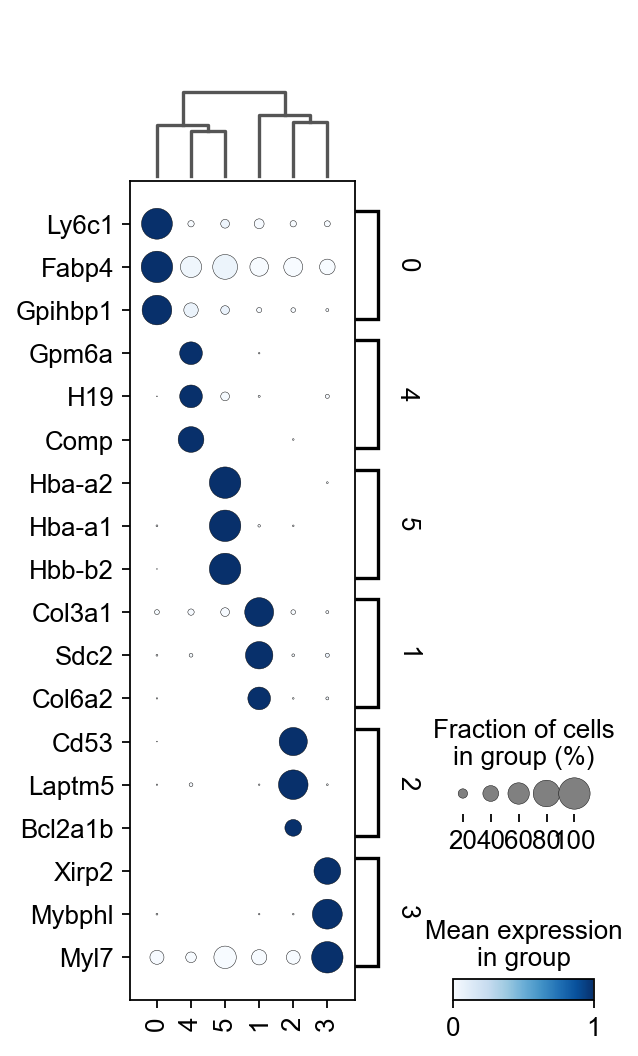

In [25]:
# adata.raw = adata
# adata.var_names = [x.lower() for x in adata.var_names]
# adata.var_names_make_unique()
sc.pl.dotplot(
    adata,
    markers,
    groupby="leiden_scVI",
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=False,
    standard_scale="var",
)

We can also visualize the scVI normalized gene expression values with the `layer` option.

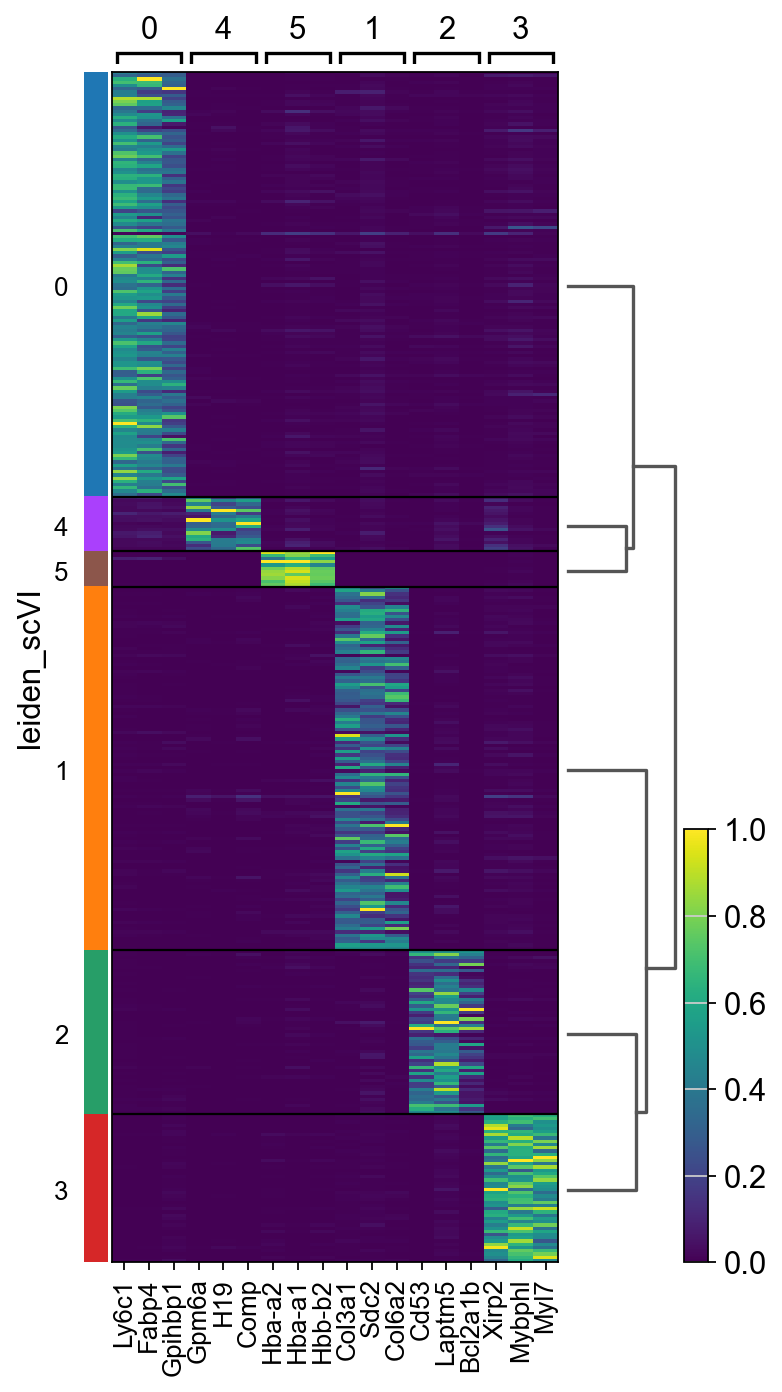

In [26]:
sc.pl.heatmap(
    adata,
    markers,
    groupby="leiden_scVI",
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(5, 10),
)